# Finding location for Store

Let's download all the dependencies that we'll need

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
# Import BeautifulSoup from bs4
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
#import matplotlib.cm as cm
#import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  48.95 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.79 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  39.99 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  48.01 MB/s


## Loading data

We need to download the postal codes data which is available in wikipedia.

In [3]:
#Store the url
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = urlopen(url)

# Create a BeautifulSoup object from the HTML
soup = BeautifulSoup(html, "lxml")
type(soup)

bs4.BeautifulSoup

In [4]:
#Get the text
text = soup.get_text()
#print(text)

In [5]:
table = soup.find('table', attrs={'class':'wikitable sortable'})
table_body = table.find('tbody')

# Print the first 10 rows 
rows = table.find_all('tr')
#print(rows[:10])

From these object extract the table data

In [6]:
# Print the first 10 rows 
rows = table.find_all('tr')
#print(rows[:10])

In [7]:
data = []

#Create a loop that iterate through table rows
for row in rows:
    table_data = row.find_all('td')
    row = [row.text for row in table_data]
    data.append(row)
df=pd.DataFrame(data, columns=["Postcode", "Borough","Neighborhood"])
df.head()

,Postcode,Borough,Neighborhood
0,None,None,None
1,M1A,Not assigned,Not assigned\n
2,M2A,Not assigned,Not assigned\n
3,M3A,North York,Parkwoods\n
4,M4A,North York,Victoria Village\n


In [8]:
df.shape

(290, 3)

In [9]:
geodata = pd.read_csv("https://cocl.us/Geospatial_data")
geodata.rename(columns = {'Postal Code' : 'Postcode'}, inplace = True)
geodata.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Pre-prosessing data for analysis

In [10]:
#Remove the cell with not assigned borough 
df['Neighborhood'] = df['Neighborhood'].str.replace('\n','')
df1=df.loc[(df['Borough'] != 'Not assigned') & (df['Postcode'].notnull())].reset_index(drop=True)
#df1.head()

In [11]:
#More than one neighborhood can exist in one postal code area. 
df1.set_index(['Postcode', 'Borough'],inplace =True)
df = df1.groupby(level=['Postcode','Borough'], sort=False).agg( ','.join)
df=df.reset_index()
df.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront,Regent Park"
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Queen's Park,Not assigned


In [12]:
df.loc[df['Neighborhood'] == 'Not assigned', ['Neighborhood']] = df['Borough']
df.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront,Regent Park"
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [13]:
#Merge dataframes
df= pd.merge(df,geodata,
                 on='Postcode', 
                 how='left')
df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


In [15]:
borough = pd.DataFrame(df['Borough'].value_counts())
#borough

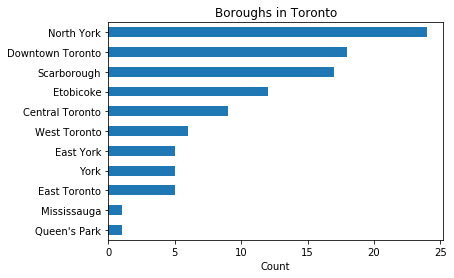

In [16]:
borough.plot(kind = 'barh',legend = None)
plt.title("Boroughs in Toronto")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.show()

### Load the map of Toronto

In [17]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [18]:
# create map of Toronto using latitude and longitude values
map_tr = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tr)  
    
map_tr

### Find Department stores in Toronto

In [19]:
# @hidden_cell
CLIENT_ID = 'PDV131Y2CVTPXUR5G1U54PCUL20DUOFQWNXA5SACNP2ROQU5' # your Foursquare ID
CLIENT_SECRET = 'RVQEBO0K05YMWX1OHKJQXO05G1JLCTAQUJA1ZYYSRUPWIGRW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [21]:
#LIMIT = 100 # limit of number of venues returned by Foursquare API

category_id = "4bf58dd8d48988d1f6941735"
radius = 5000 # define radius

 # create URL
url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&&intent=browse&v={}&radius={}'.format(
    category_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,
    VERSION,
    radius
    )
url # display URL    



'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d1f6941735&client_id=PDV131Y2CVTPXUR5G1U54PCUL20DUOFQWNXA5SACNP2ROQU5&client_secret=RVQEBO0K05YMWX1OHKJQXO05G1JLCTAQUJA1ZYYSRUPWIGRW&v=20180605&ll=43.653963,-79.387207&&intent=browse&v=20180605&radius=5000'

In [22]:
results = requests.get(url).json()
#results

In [23]:
venues =results['response']['venues'] # results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['name','location.lat', 'location.lng', 'location.postalCode']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,lat,lng,postalCode
0,Hudson's Bay,43.652040,-79.380391,M5C 2L7
1,Nordstrom Rack,43.670006,-79.386753,M4Y 2B6
2,Nordstrom,43.655041,-79.380966,M5B 2L9
3,Marshalls,43.659108,-79.382568,M5B 1S8
4,HomeSense,43.653187,-79.379237,M5B 1M4


In [24]:
nearby_venues['Postcode'] =nearby_venues.postalCode.str.slice(0, 3)
nearby_venues = nearby_venues.dropna()
del nearby_venues['postalCode']
#nearby_venues

In [25]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

23 venues were returned by Foursquare.


In [26]:
store_df= pd.merge(nearby_venues,df,
                 on='Postcode', 
                 how='left')
del store_df['Latitude']
del store_df['Longitude']
del store_df['Postcode']
store_df.head()

,name,lat,lng,Borough,Neighborhood
0,Hudson's Bay,43.652040,-79.380391,Downtown Toronto,St. James Town
1,Nordstrom Rack,43.670006,-79.386753,Downtown Toronto,Church and Wellesley
2,Nordstrom,43.655041,-79.380966,Downtown Toronto,"Ryerson,Garden District"
3,Marshalls,43.659108,-79.382568,Downtown Toronto,"Ryerson,Garden District"
4,HomeSense,43.653187,-79.379237,Downtown Toronto,"Ryerson,Garden District"


In [27]:
store_df.shape

(23, 5)

### create a map of existing store locations

In [28]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [29]:
#Map Stores
map_store = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for name, lat, lng, borough, neighborhood in zip(store_df['name'], store_df['lat'], store_df['lng'], store_df['Borough'], store_df['Neighborhood']):
    label = '{}, {}, {}'.format(name, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_store)  
    
map_store

In [30]:
D_stores =pd.DataFrame(store_df['Borough'].value_counts())

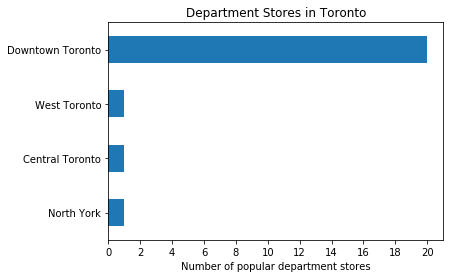

In [31]:
D_stores.plot(kind = 'barh',legend = None)
plt.title("Department Stores in Toronto")
plt.xlabel("Number of popular department stores")
plt.xticks(np.arange(0,21, 2.0))
plt.gca().invert_yaxis()

plt.show()